### Regressao Logistica em R

#### Motivaçao:
 - O conceito do Z-Score
 - O que nao te contam nos livros
 - Construindo mais variaveis para o modelo
 - Treinamento e avaliaçao do Modelo
 - Area Under the Curve (AUC) ROC e o Gini
 - Resultados:
     - "Retorno de 2009 à 2019:  51.32 %%"
     - "Retorno juros simples por ano:  4.67%"
 - Consideraçoes finais

_____________________________________________

### Bibliotecas

In [1]:
library(stats)
library(rattle)
library(caret)
library(ROCR)
library(party)
library(mlbench)
library(quantmod)
library(e1071)
library(data.table)
library(tidyverse)

Warning message:
"package 'rattle' was built under R version 3.6.2"Rattle: A free graphical interface for data science with R.
Version 5.3.0 Copyright (c) 2006-2018 Togaware Pty Ltd.
Type 'rattle()' to shake, rattle, and roll your data.
Loading required package: lattice
Loading required package: ggplot2
Loading required package: gplots

Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess

Warning message:
"package 'party' was built under R version 3.6.2"Loading required package: grid
Loading required package: mvtnorm
Loading required package: modeltools
Loading required package: stats4
Loading required package: strucchange
Warning message:
"package 'strucchange' was built under R version 3.6.2"Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: sandwich
Warning message:
"package 'mlbench' was built under R version 3.6.2"Loading re

_____________________________________________

### Carregando a base de dados

In [2]:
# Muda o diretorio de trabalho

setwd('C:/Users/engle/OM Na Pratica/Finanças Quantitativas/Bases de Dados')

In [3]:
# Importando arquivos do tipo CSV - funcao fread

#Carregando o Dataset e ajustando a data
EURUSD <- fread("EURUSD_D1_Reg_Log.csv", header = TRUE, sep = ";")

EURUSD <- data.frame(EURUSD)

names(EURUSD)[1] <- "DATE"

EURUSD$DATE <- as.POSIXct(strptime(EURUSD$DATE, format= "%d/%m/%Y"))

In [4]:
head(EURUSD)
tail(EURUSD)

DATE,Open,High,Low,Close
2003-05-05,1.12728,1.14506,1.12723,1.14338
2003-05-06,1.14297,1.14438,1.13265,1.13647
2003-05-07,1.13605,1.15077,1.13006,1.14996
2003-05-08,1.14932,1.15366,1.14346,1.14877
2003-05-11,1.14888,1.16229,1.14888,1.15427
2003-05-12,1.15357,1.15739,1.14620,1.15120


,DATE,Open,High,Low,Close
4323,2019-11-28,1.09987,1.10179,1.09986,1.10067
4324,2019-11-29,1.10059,1.10282,1.09811,1.10150
4325,2019-12-02,1.10229,1.10907,1.10029,1.10784
4326,2019-12-03,1.10782,1.10934,1.10660,1.10809
4327,2019-12-04,1.10809,1.11161,1.10666,1.10775
4328,2019-12-05,1.10772,1.10772,1.11078,1.10977


_____________________________________________

### O Z-Score

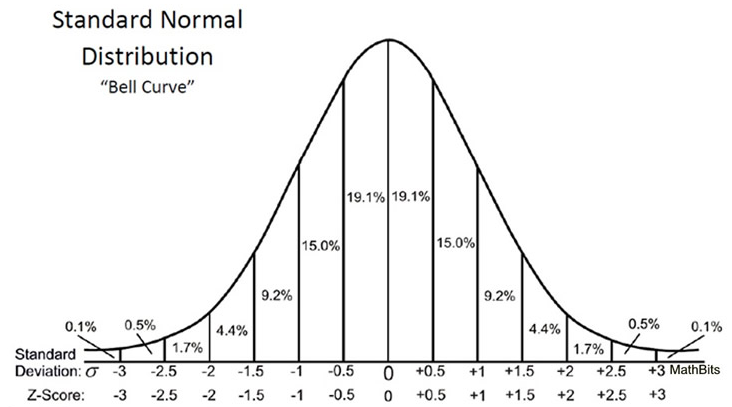

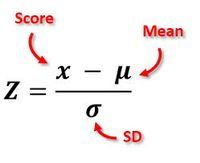

In [5]:
# Calculando os retornos e o alvo

# Calculando os retornos e o alvo
EURUSD <- mutate(EURUSD, Close_lead = lead(Close))
EURUSD <- mutate(EURUSD, Close_lag = lag(Close)) # vai criar um NA na primeira linha

EURUSD <- na.omit(EURUSD)

EURUSD$Return <- (EURUSD$Close/EURUSD$Close_lag-1)*100
EURUSD$Alvo1 <- (EURUSD$Close_lead/EURUSD$Close-1)*100
EURUSD$Alvo1_Bin <- ifelse(EURUSD$Alvo1 > 0, 1,0)



head(EURUSD)

,DATE,Open,High,Low,Close,Close_lead,Close_lag,Return,Alvo1,Alvo1_Bin
2,2003-05-06,1.14297,1.14438,1.13265,1.13647,1.14996,1.14338,-0.6043485,1.1870089,1
3,2003-05-07,1.13605,1.15077,1.13006,1.14996,1.14877,1.13647,1.1870089,-0.1034819,0
4,2003-05-08,1.14932,1.15366,1.14346,1.14877,1.15427,1.14996,-0.1034819,0.4787729,1
5,2003-05-11,1.14888,1.16229,1.14888,1.15427,1.15120,1.14877,0.4787729,-0.2659690,0
6,2003-05-12,1.15357,1.15739,1.14620,1.15120,1.14940,1.15427,-0.2659690,-0.1563586,0
7,2003-05-13,1.15120,1.15370,1.14667,1.14940,1.13847,1.15120,-0.1563586,-0.9509309,0


In [6]:
# Calculando o Z-Score

#install.packages("caTools")
library(caTools)

In [7]:
# Calculando a média movel dos retornos e o desvio padrao

periodo_mm <- 15

EURUSD$MA_Return <- c(rep(NA, periodo_mm-1),runmean(EURUSD$Return, periodo_mm, alg=c("C"), endrule=c("trim")))

EURUSD$SD_Return <- c(rep(NA, periodo_mm-1),runsd(EURUSD$Return, periodo_mm, endrule=c("trim")))

EURUSD$ZScore <- (EURUSD$Return-EURUSD$MA_Return)/EURUSD$SD_Return

head(EURUSD)

write.csv(EURUSD,"teste_media.csv", row.names = FALSE)


,DATE,Open,High,Low,Close,Close_lead,Close_lag,Return,Alvo1,Alvo1_Bin,MA_Return,SD_Return,ZScore
2,2003-05-06,1.14297,1.14438,1.13265,1.13647,1.14996,1.14338,-0.6043485,1.1870089,1,NA,NA,NA
3,2003-05-07,1.13605,1.15077,1.13006,1.14996,1.14877,1.13647,1.1870089,-0.1034819,0,NA,NA,NA
4,2003-05-08,1.14932,1.15366,1.14346,1.14877,1.15427,1.14996,-0.1034819,0.4787729,1,NA,NA,NA
5,2003-05-11,1.14888,1.16229,1.14888,1.15427,1.15120,1.14877,0.4787729,-0.2659690,0,NA,NA,NA
6,2003-05-12,1.15357,1.15739,1.14620,1.15120,1.14940,1.15427,-0.2659690,-0.1563586,0,NA,NA,NA
7,2003-05-13,1.15120,1.15370,1.14667,1.14940,1.13847,1.15120,-0.1563586,-0.9509309,0,NA,NA,NA


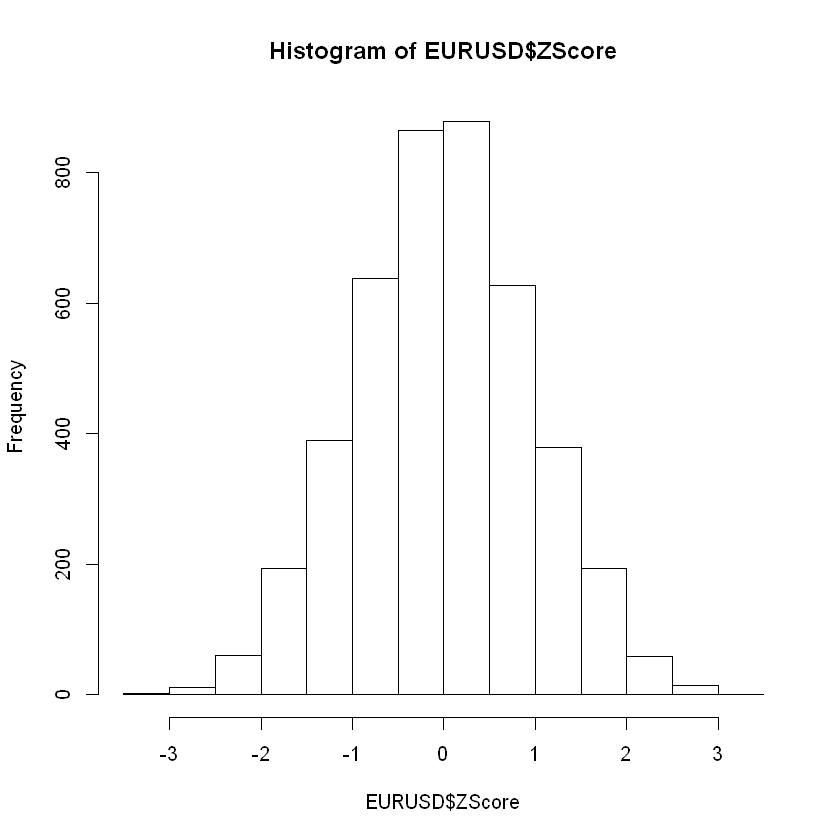

In [8]:
hist(EURUSD$ZScore)

In [9]:
# Calculando o RSL
EURUSD$MA_Close <- c(rep(NA, periodo_mm-1),runmean(EURUSD$Close, periodo_mm, alg=c("C"), endrule=c("trim")))
EURUSD$RSL <- (EURUSD$Close/EURUSD$MA_Close-1)

EURUSD <- na.omit(EURUSD)

tail(EURUSD)

,DATE,Open,High,Low,Close,Close_lead,Close_lag,Return,Alvo1,Alvo1_Bin,MA_Return,SD_Return,ZScore,MA_Close,RSL
4322,2019-11-27,1.10194,1.10246,1.09922,1.09989,1.10067,1.10194,-0.18603554,0.07091618,1,-0.040261868,0.1831719,-0.79582996,1.103417,-0.003196133
4323,2019-11-28,1.09987,1.10179,1.09986,1.10067,1.10150,1.09989,0.07091618,0.07540861,1,-0.025834568,0.1828137,0.52923144,1.103130,-0.002230018
4324,2019-11-29,1.10059,1.10282,1.09811,1.10150,1.10784,1.10067,0.07540861,0.57557876,1,-0.001440285,0.1688543,0.45511949,1.103113,-0.001461924
4325,2019-12-02,1.10229,1.10907,1.10029,1.10784,1.10809,1.10150,0.57557876,0.02256644,1,0.028036773,0.2237496,2.44711922,1.103420,0.004005728
4326,2019-12-03,1.10782,1.10934,1.10660,1.10809,1.10775,1.10784,0.02256644,-0.03068343,0,0.043741928,0.2136621,-0.09910741,1.103901,0.003795027
4327,2019-12-04,1.10809,1.11161,1.10666,1.10775,1.10977,1.10809,-0.03068343,0.18235161,1,0.043815882,0.2136342,-0.34872365,1.104382,0.003049669


In [10]:
#Treinamento e teste - 2003-2008
desenvolvimento <- EURUSD[1:1443,]


In [11]:
summary(desenvolvimento$ZScoreQ)

Length  Class   Mode 
     0   NULL   NULL 

In [12]:
# Serà que o Z-Score ajudar a encontrar regioes mais rentaveis?
# O que nao te contam nos livros

q <- quantile(desenvolvimento$ZScore, seq(0, 1, by = 0.05))

desenvolvimento$ZScoreQ <- cut(desenvolvimento$ZScore, q, include.lowest = TRUE)

Returns_ZScore <- aggregate(Alvo1 ~ ZScoreQ, data = desenvolvimento, FUN = sum)
Returns_ZScore

ZScoreQ,Alvo1
"[-2.69,-1.62]",-3.794387
"(-1.62,-1.26]",-5.341415
"(-1.26,-1.02]",-3.699640
"(-1.02,-0.84]",5.860447
"(-0.84,-0.677]",3.877997
"(-0.677,-0.507]",5.059998
"(-0.507,-0.377]",5.113554
"(-0.377,-0.238]",2.547562
"(-0.238,-0.125]",4.152480
"(-0.125,-0.0113]",5.551615


In [13]:
# Serà que o RSL ajudar a encontrar regioes mais rentaveis?

q <- quantile(desenvolvimento$RSL, seq(0, 1, by = 0.1))
desenvolvimento$RSLQ <- cut(desenvolvimento$RSL, q, include.lowest = TRUE)

Returns_RSL <- aggregate(Alvo1 ~ RSLQ, data = desenvolvimento, FUN = sum)
Returns_RSL

RSLQ,Alvo1
"[-0.0588,-0.0151]",2.9349837
"(-0.0151,-0.00953]",-6.4518078
"(-0.00953,-0.00538]",8.0896218
"(-0.00538,-0.00217]",3.2550560
"(-0.00217,0.00123]",-0.1884455
"(0.00123,0.00421]",3.2709853
"(0.00421,0.00775]",-7.5591655
"(0.00775,0.0113]",12.3384495
"(0.0113,0.0157]",5.4099923
"(0.0157,0.0338]",-11.2154858


_____________________________________________

### Construindo mais variaveis para o modelo

In [14]:
# Criando os indicadores técnicos

EURUSD$RSI <- RSI(EURUSD$Close, 14, "SMA")
EURUSD$RSI2 <- RSI(EURUSD$Close, 2, "SMA")
EURUSD$CCI <- CCI(EURUSD$Close, 14)
EURUSD$MACD <- MACD(EURUSD$Close, 12, 26, 9, "SMA") 
EURUSD$MACD <- EURUSD$MACD[,1] - EURUSD$MACD[,2] 
EURUSD$Bbands <- BBands(EURUSD$Close, 20, "SMA", 2)[,4]

In [15]:
# Criando as variaveis

EURUSD$ZScoreBin <- ifelse((EURUSD$ZScore <= -1.02 | (EURUSD$ZScore > 0.476 & EURUSD$ZScore <= 1.62))
                           , 1, 0)
EURUSD$RSLBin <- ifelse((
                        (EURUSD$RSL > -0.00956 & EURUSD$RSL <= -0.00523)|
                        (EURUSD$RSL > 0.00981 & EURUSD$RSL <= 0.0135)|
                        (EURUSD$RSL > 0.00149 & EURUSD$RSL <= 0.00438)
                        )
                        , 1, 0)

EURUSD$RSIH <- ifelse(EURUSD$RSI > 70, 1, 0)
EURUSD$RSIL <- ifelse(EURUSD$RSI < 30, 1, 0)
EURUSD$RSI2H <- ifelse(EURUSD$RSI2 > 70, 1, 0)
EURUSD$RSI2L <- ifelse(EURUSD$RSI2 < 30, 1, 0)
EURUSD$CCIH <- ifelse(EURUSD$CCI > 120, 1, 0)
EURUSD$CCIL <- ifelse(EURUSD$CCI < -120, 1, 0)
EURUSD$MACDH <- ifelse(EURUSD$MACD > 0.5, 1, 0)
EURUSD$MACDL <- ifelse(EURUSD$MACD < -0.5, 1, 0)

EURUSD <- na.omit(EURUSD)

names(EURUSD)

[1] "DATE"       "Open"       "High"       "Low"        "Close"     
 [6] "Close_lead" "Close_lag"  "Return"     "Alvo1"      "Alvo1_Bin" 
[11] "MA_Return"  "SD_Return"  "ZScore"     "MA_Close"   "RSL"       
[16] "RSI"        "RSI2"       "CCI"        "MACD"       "Bbands"    
[21] "ZScoreBin"  "RSLBin"     "RSIH"       "RSIL"       "RSI2H"     
[26] "RSI2L"      "CCIH"       "CCIL"       "MACDH"      "MACDL"

_____________________________________________

### Treinamento do Modelo

In [16]:
#Treinamento e teste - 2003-2008
desenvolvimento <- EURUSD[1:1443,]
#desenvolvimento <- EURUSD[1:2211,]
#Validacao - 2009-2019
validacao <- EURUSD[1444:dim(EURUSD)[1],]
#validacao <- EURUSD[2212:dim(EURUSD)[1],]

tail(desenvolvimento)

,DATE,Open,High,Low,Close,Close_lead,Close_lag,Return,Alvo1,Alvo1_Bin,...,ZScoreBin,RSLBin,RSIH,RSIL,RSI2H,RSI2L,CCIH,CCIL,MACDH,MACDL
1486,2009-01-13,1.33614,1.33730,1.31402,1.31800,1.31905,1.33600,-1.34730539,0.07966616,1,...,1,0,0,1,0,1,0,1,0,1
1487,2009-01-14,1.31810,1.33370,1.30940,1.31905,1.31135,1.31800,0.07966616,-0.58375346,0,...,1,0,0,1,0,1,0,1,0,1
1488,2009-01-15,1.31880,1.32340,1.30247,1.31135,1.32640,1.31905,-0.58375346,1.14767225,1,...,0,0,0,1,0,1,0,1,0,1
1489,2009-01-16,1.31125,1.33425,1.31110,1.32640,1.30670,1.31135,1.14767225,-1.48522316,0,...,1,0,0,0,0,0,0,0,0,1
1490,2009-01-19,1.33352,1.33845,1.30655,1.30670,1.29037,1.32640,-1.48522316,-1.24971302,0,...,1,0,0,1,0,0,0,0,0,1
1491,2009-01-20,1.30660,1.31035,1.28560,1.29037,1.30215,1.30670,-1.24971302,0.91291645,1,...,0,0,0,1,0,1,0,1,0,1


In [17]:
set.seed(42)
inTrain <- createDataPartition(y = desenvolvimento$Alvo1_Bin, p = 0.7, list=FALSE)
training <- desenvolvimento[inTrain,]
testing <- desenvolvimento[-inTrain,]
dim(training); dim(testing)

[1] 1011   30

[1] 432  30

In [18]:
# Regressão Logística

modelo1 <- glm(Alvo1_Bin ~ ZScoreBin + RSLBin + RSIH + RSIL + RSI2H + RSI2L + Bbands + MACDH + MACDL + CCIH + CCIL,
                 data = training, family = binomial(link = 'logit'))  

summary(modelo1)


Call:
glm(formula = Alvo1_Bin ~ ZScoreBin + RSLBin + RSIH + RSIL + 
    RSI2H + RSI2L + Bbands + MACDH + MACDL + CCIH + CCIL, family = binomial(link = "logit"), 
    data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6626  -1.1530   0.8264   1.1341   1.6679  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.47616    0.23900   1.992  0.04634 *  
ZScoreBin   -0.53741    0.13257  -4.054 5.04e-05 ***
RSLBin       0.41212    0.14610   2.821  0.00479 ** 
RSIH         0.01890    0.20561   0.092  0.92678    
RSIL         0.19954    0.24683   0.808  0.41885    
RSI2H       -0.41102    0.18324  -2.243  0.02489 *  
RSI2L       -0.10136    0.18561  -0.546  0.58500    
Bbands       0.02224    0.34396   0.065  0.94845    
MACDH       -0.45128    0.23064  -1.957  0.05039 .  
MACDL       -0.51375    0.22680  -2.265  0.02350 *  
CCIH        -0.21988    0.23382  -0.940  0.34704    
CCIL        -0.21757    0.25303  -0.860  0.38987   

In [19]:
# Deixando apenas as variaveis mais relevantes

modelo1 <- glm(Alvo1_Bin ~ ZScoreBin + RSLBin + RSIL + RSI2H + RSI2L + MACDH + MACDL,
                 data = training, family = binomial(link = 'logit'))  

summary(modelo1)


Call:
glm(formula = Alvo1_Bin ~ ZScoreBin + RSLBin + RSIL + RSI2H + 
    RSI2L + MACDH + MACDL, family = binomial(link = "logit"), 
    data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6463  -1.1457   0.8259   1.1382   1.6361  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.4730     0.1622   2.917  0.00354 ** 
ZScoreBin    -0.5493     0.1316  -4.174 2.99e-05 ***
RSLBin        0.4273     0.1452   2.943  0.00326 ** 
RSIL          0.1567     0.2318   0.676  0.49901    
RSI2H        -0.4685     0.1707  -2.745  0.00606 ** 
RSI2L        -0.1554     0.1750  -0.888  0.37481    
MACDH        -0.4270     0.2242  -1.905  0.05682 .  
MACDL        -0.4896     0.2233  -2.192  0.02838 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1401.1  on 1010  degrees of freedom
Residual deviance: 1358.4  on 1003  degrees of freedom
AIC:

_____________________________________________

### Avaliaçao do Modelo 1 - Teste

In [20]:
modelo1


Call:  glm(formula = Alvo1_Bin ~ ZScoreBin + RSLBin + RSIL + RSI2H + 
    RSI2L + MACDH + MACDL, family = binomial(link = "logit"), 
    data = training)

Coefficients:
(Intercept)    ZScoreBin       RSLBin         RSIL        RSI2H        RSI2L  
     0.4730      -0.5493       0.4273       0.1567      -0.4685      -0.1554  
      MACDH        MACDL  
    -0.4270      -0.4896  

Degrees of Freedom: 1010 Total (i.e. Null);  1003 Residual
Null Deviance:	    1401 
Residual Deviance: 1358 	AIC: 1374

[1] 0.53

[1] 0.06

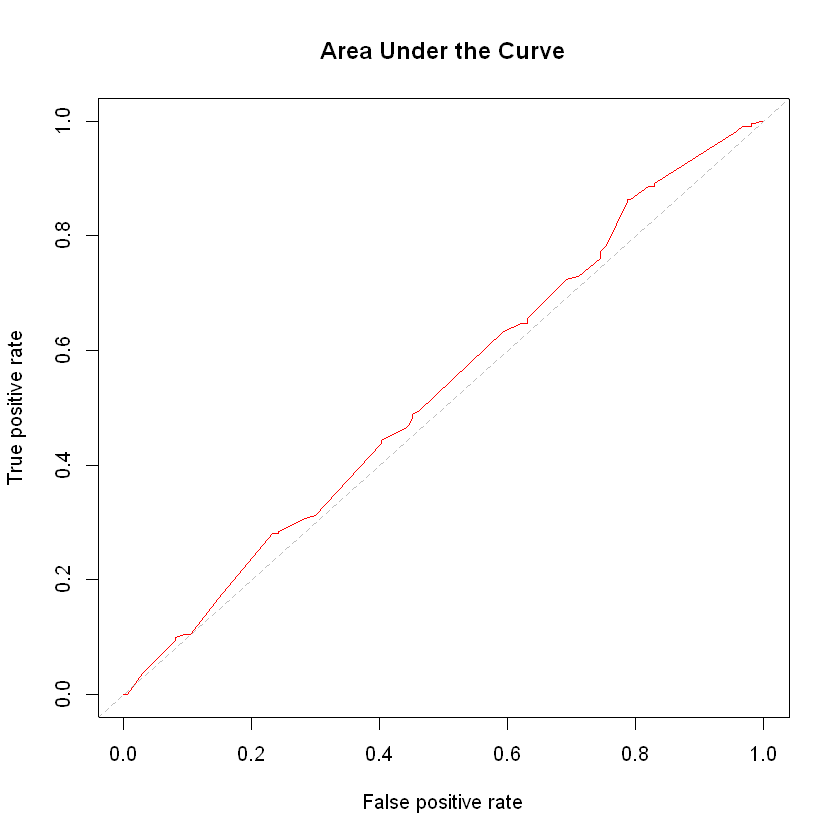

In [21]:
# Plota a AUC

probabilidades <- predict(modelo1, type = 'response', testing) 
modelo1_data <- prediction(probabilidades, testing$Alvo1_Bin)
plot(performance(modelo1_data, "tpr", "fpr"), col = "red", main = "Area Under the Curve")
abline(0,1, lty = 8, col = "grey")

# AUC
auc_rdock <- performance(modelo1_data, "auc")
auc.area_rdock <- slot(auc_rdock, "y.values")[[1]]
round(auc.area_rdock, 2)

# Gini
gini_fin_test <- 2*auc.area_rdock-1
round(gini_fin_test, 2)

In [22]:
# Ordenação por classe de score

classe <- cut(probabilidades, quantile(probabilidades, seq(0,1,0.15)))

table(classe, testing$Alvo1_Bin)

               
classe           0  1
  (0.262,0.396] 43 30
  (0.396,0.481] 34 46
  (0.481,0.501] 36 36
  (0.501,0.579] 34 40
  (0.579,0.606] 32 32
  (0.606,0.616] 11 14

In [23]:
# Taxa de Alta/Baixa

round(table(classe, testing$Alvo1_Bin)[,2]/(table(classe, testing$Alvo1_Bin)[,1] + table(classe, testing$Alvo1_Bin)[,2]),3)*100

(0.262,0.396] (0.396,0.481] (0.481,0.501] (0.501,0.579] (0.579,0.606] 
         41.1          57.5          50.0          54.1          50.0 
(0.606,0.616] 
         56.0

In [24]:
corte_low <- 0.396
corte_up <- 0.606

_____________________________________________

### Avaliaçao do Modelo 1 - Validaçao

[1] 0.53

[1] 0.05

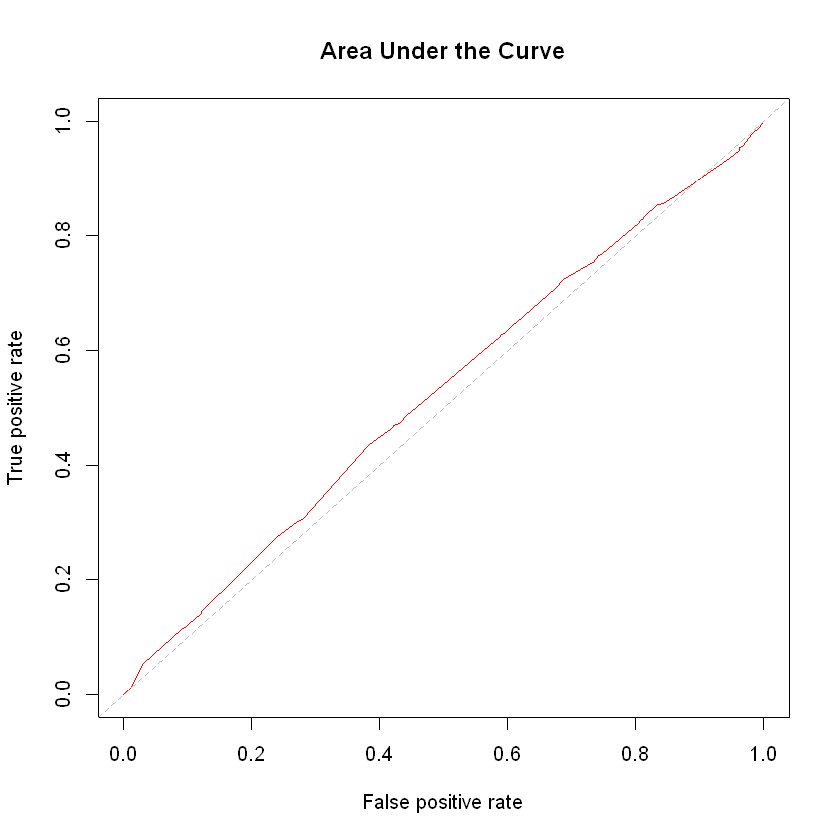

In [25]:
#Plota a ROC
probabilidades_val <- predict(modelo1,type = 'response',validacao) 
modelo1_data_val <- prediction(probabilidades_val, validacao$Alvo1_Bin)
plot(performance(modelo1_data_val, "tpr", "fpr"), col = "red", main = "Area Under the Curve")
abline(0,1, lty = 8, col = "grey")

#AUC
auc_rdock_val <- performance(modelo1_data_val, "auc")
auc.area_rdock_val <- slot(auc_rdock_val, "y.values")[[1]]
round(auc.area_rdock_val,2)

#Gini
gini_fin_test_val <- 2*auc.area_rdock_val-1
round(gini_fin_test_val,2)

_____________________________________________

### Avaliaçao da Performance

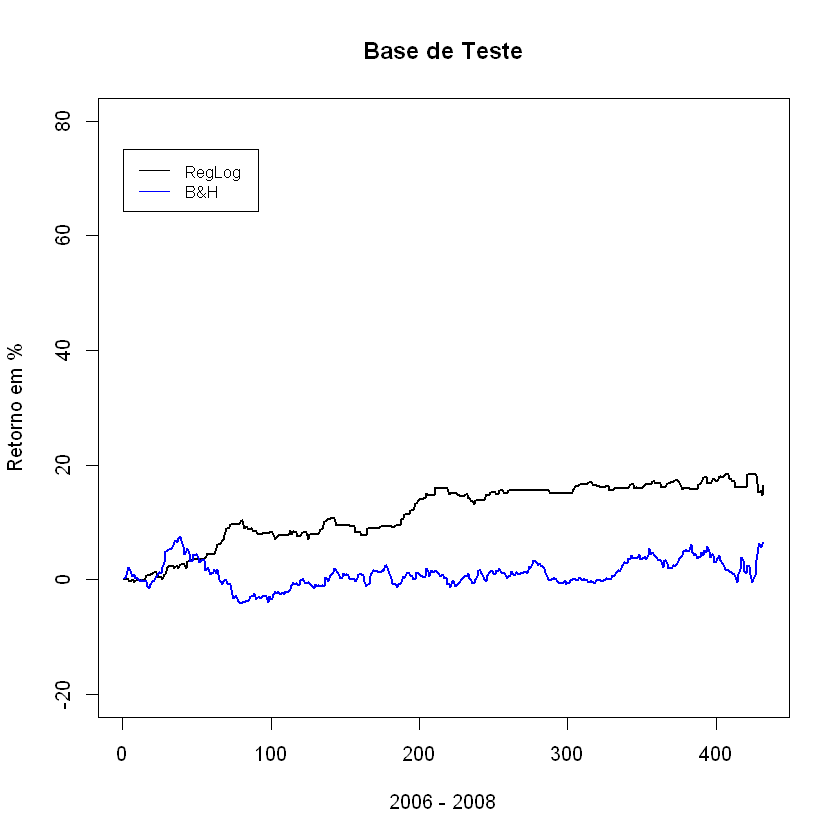

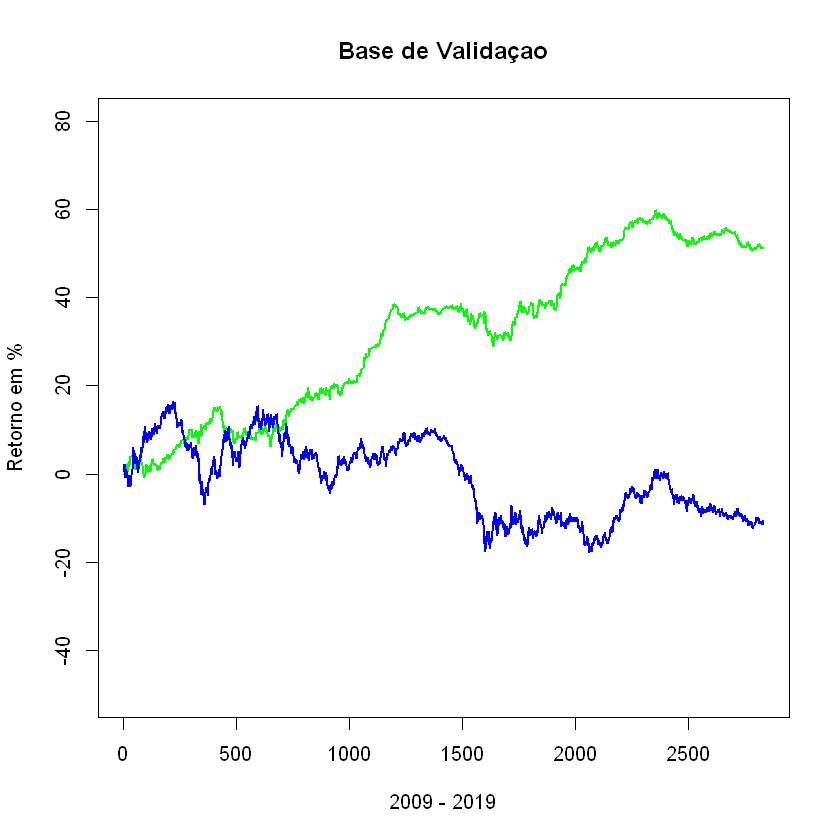

In [26]:
par(mfrow=c(1,1))

# Custos operacionais
custo_op <- 0.01 # Em percentual - No forex é realmente muito baixo.

# Teste
testing$predicao <- predict(modelo1, type='response',testing) 

retorno_BH <- ifelse(testing$Return > 0, testing$Return, testing$Return)
retorno_BH_acumulado <- cumsum(retorno_BH)

retorno_modelo1 <- ifelse(testing$predicao > corte_up, testing$Alvo1 - custo_op,
                          ifelse(testing$predicao < corte_low, -1*testing$Alvo1 - custo_op,0))

retorno_modelo1_acumulado <- cumsum(retorno_modelo1)


plot(retorno_modelo1_acumulado, type = "l", col = "black", lwd = 2,
     main = "Base de Teste",
     xlab = "2006 - 2008",
     ylab = "Retorno em %",
     ylim = c(-20,80))
lines(retorno_BH_acumulado,col = "blue", lwd = 2)

legend(1, 75, legend = c("RegLog","B&H"),
       col = c("black","blue"), lty = 1:1, cex = 0.8)


# Validacao
validacao$predicao <- predict(modelo1, type ='response', validacao) 

retorno_BH <- ifelse(validacao$Return > 0, validacao$Return, validacao$Return)
retorno_BH_acumulado <- cumsum(retorno_BH)

retorno_modelo1 <- ifelse(validacao$predicao > corte_up, validacao$Alvo1 - custo_op,
                          ifelse(validacao$predicao < corte_low, -1*validacao$Alvo1 - custo_op,0))

retorno_modelo1_acumulado <- cumsum(retorno_modelo1)

# Grafico da Performance

plot(retorno_modelo1_acumulado, type = "l", col = "green", lwd = 2,
     main = "Base de Validaçao",
     xlab = "2009 - 2019",
     ylab = "Retorno em %",
     ylim = c(-50,80))
lines(retorno_BH_acumulado, col = "blue", lwd = 2)

legend(1, 160, legend = c("RegLog", "B&H"),
       col = c("green","blue"), lty = 1:1, cex = 0.8)


In [27]:
# Retorno acumulado em quase 11 anos

print(paste("Retorno de 2009 à 2019: " ,round(last(retorno_modelo1_acumulado),2), "%"))

print(paste("Retorno juros simples por ano: " ,round(last(retorno_modelo1_acumulado)/11,2), "%"))

[1] "Retorno de 2009 à 2019:  51.32 %"
[1] "Retorno juros simples por ano:  4.67 %"


_____________________________________________

### Consideraçoes Finais

 - A avaliaçao de performance nao è com juros compostos, apenas simples e sem aumento de capital
 - Ou seja, os retornos podem ser muito maiores
 - Os custos operacionais sao baixos no Forex, mas possuem impacto relevante em mercados como o do Brasil
 - Os Ginis sao medianos;
 - Porém, no mercado financeiro qualquer coisa que acerte mais que uma moeda te dà um alpha
 - Quais novas variàveis podemos pensar?
 - Tema para as proximas aulas